In [60]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [61]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [62]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [63]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

/var/folders/fh/yyvhpn113335mp4hfgkzm2sm0000gn/T/ipykernel_79608/631302914.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [64]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [65]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [66]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [67]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

print(f"The most recent date in the dataset is: {most_recent_date}")


The most recent date in the dataset is: 2017-08-23


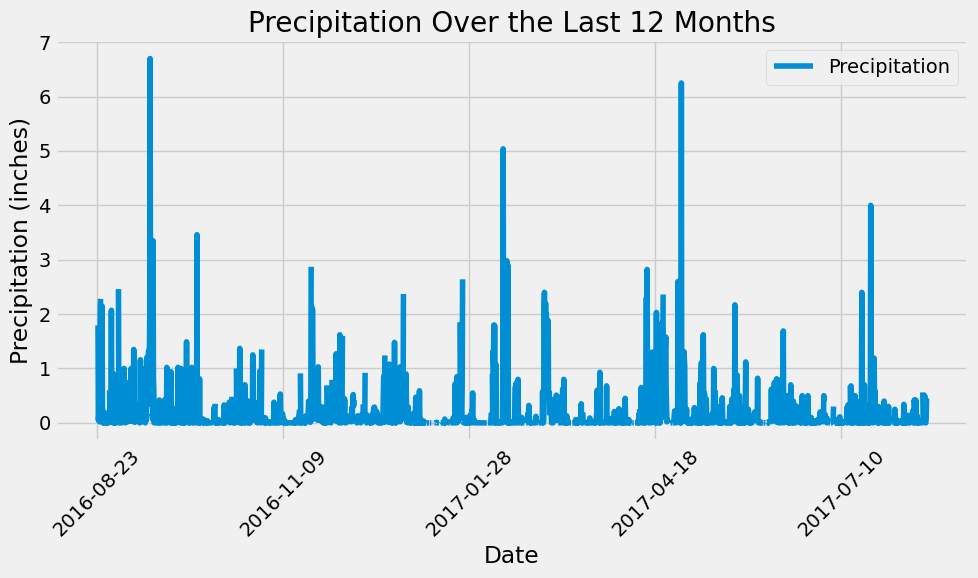

2017-08-23 00:00:00


In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Convert the most recent date string to a datetime object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Convert one_year_ago to a string
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame, explicitly setting the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Over the Last 12 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(most_recent_date)



In [69]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()

display(summary_statistics)


Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

# Exploratory Station Analysis

In [70]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f'The total number of stations in the dataset is: {total_stations}')


The total number of stations in the dataset is: 9


In [71]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
# Print the results
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station ID: {station}, Count: {count}")

Most Active Stations:
Station ID: USC00519281, Count: 2772
Station ID: USC00519397, Count: 2724
Station ID: USC00513117, Count: 2709
Station ID: USC00519523, Count: 2669
Station ID: USC00516128, Count: 2612
Station ID: USC00514830, Count: 2202
Station ID: USC00511918, Count: 1979
Station ID: USC00517948, Count: 1372
Station ID: USC00518838, Count: 511


In [75]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Get the most active station ID (assuming it's the first station in the list)
most_active_station = active_stations[0][0]

# Design a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
                        filter(Measurement.station == most_active_station).all()

# Print the results
print(f"Temperature statistics for station {most_active_station}:")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")


Temperature statistics for station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


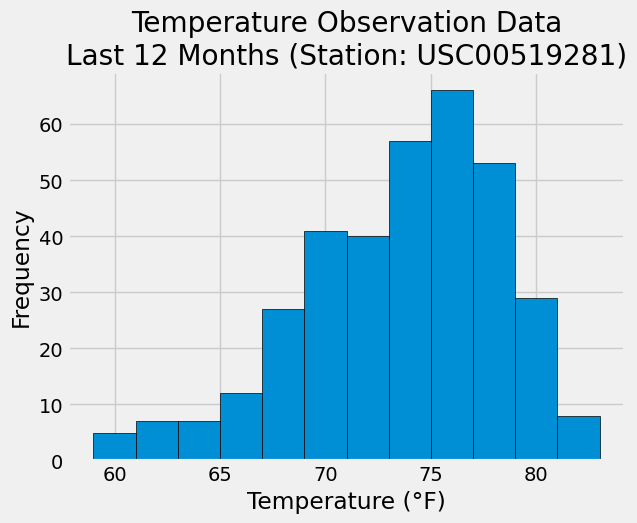

In [73]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Convert one_year_ago to a string
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Design a query to retrieve the last 12 months of temperature observation (TOBS) data for the most active station
tobs_data = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
            filter(Measurement.date >= one_year_ago_str).all()

# Convert the query result to a list
tobs_list = [result[0] for result in tobs_data]

# Plot the results as a histogram
plt.hist(tobs_list, bins=12, edgecolor='black')
plt.xlabel('Temperature (Â°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data\nLast 12 Months (Station: {most_active_station})')
plt.grid(True)
plt.show()



# Close Session

In [74]:
# Close Session
session.close()